# Libraries

In [3]:
!pip install --q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.3 MB/s eta 0:00:00


In [1]:
!pip install --q sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.3 MB/s eta 0:00:00


In [4]:
import datasets
import numpy as np
import pandas as pd
import transformers
import torch
from sklearn.metrics import accuracy_score, log_loss
import re
from tqdm.auto import tqdm
from transformers import T5Tokenizer, T5ForConditionalGeneration
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Load Dataset

In [6]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("lukaemon/bbh", "sports_understanding")
test_dataset = dataset['test']

# Load the dataset
dataset = load_dataset("tasksource/bigbench", "sports_understanding")
train_dataset = dataset['train']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating test split:   0%|          | 0/250 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for tasksource/bigbench contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/tasksource/bigbench
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

# Load Model

In [7]:
import pandas as pd
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from sklearn.metrics import accuracy_score
from transformers import T5Tokenizer, T5ForConditionalGeneration
from tqdm import tqdm

# Initialize the tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large")

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

# Use API

In [66]:
from getpass import getpass
token = getpass()

··········


In [25]:
import requests

def make_query(data_payload):
    api_endpoint = "https://api-inference.huggingface.co/models/google/flan-t5-large"
    api_token = token
    headers = {"Authorization": f"Bearer {api_token}"}

    json_data = {
        "inputs": data_payload,
        "parameters": {"max_length": 128},
        "wait_for_model": True
    }

    api_response = requests.post(api_endpoint, headers=headers, json=json_data)
    return api_response.json()

# Prompt answer only

In [8]:
X_test = test_dataset['input']
y_test = test_dataset['target']

## API

100%|██████████| 250/250 [03:10<00:00,  1.31it/s]

Accuracy: 0.584


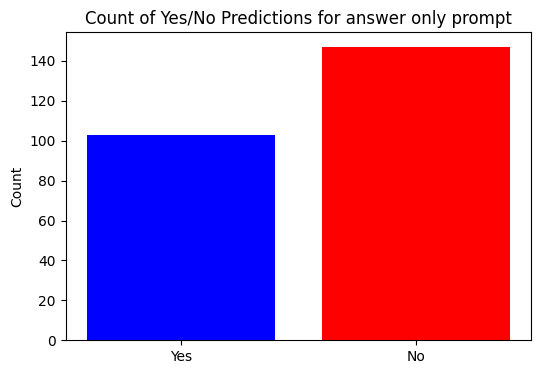

In [27]:
predictions = []

for question in tqdm(X_test):
    formatted_input = f"Given the statement: {question} Is the statement true or false? Please respond 'yes' for true and 'no' for false."
    api_response = make_query(formatted_input)

    # Check if the API response contains the expected output
    if "error" in api_response:
        print(f"Error for input {formatted_input}: {api_response['error']}")
        continue

    raw_prediction = api_response[0]['generated_text']
    prediction = "yes" if "yes" in raw_prediction.lower() else "no"
    predictions.append(prediction)

# Rest of your code for saving results and plotting remains the same
results_df = pd.DataFrame({'Input': X_test, 'Actual Target': y_test, 'Predicted': predictions})
results_df.to_csv('model_answer_only_api.csv', index=False)

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

yes_count = predictions.count('yes')
no_count = predictions.count('no')

plt.figure(figsize=(6, 4))
plt.bar(['Yes', 'No'], [yes_count, no_count], color=['blue', 'red'])
plt.ylabel('Count')
plt.title('Count of Yes/No Predictions for answer only prompt')
plt.show()


## model output

100%|██████████| 250/250 [04:18<00:00,  1.03s/it]

Accuracy: 0.584


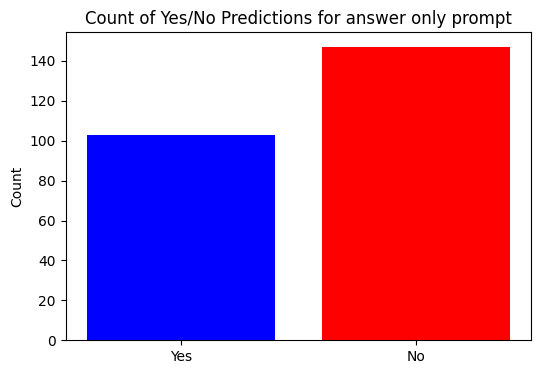

In [30]:
predictions = []
for question in tqdm(X_test):
    formatted_input = f"Given the Question: {question} Is the Question true or false? Please respond 'yes' for true and 'no' for false."
    inputs = tokenizer(formatted_input, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model.generate(inputs['input_ids'], max_length=128)
    raw_prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Post-process to get a yes/no answer
    prediction = "yes" if "yes" in raw_prediction.lower() else "no"
    predictions.append(prediction)

# Save predictions and actual targets to a CSV file
results_df = pd.DataFrame({'Input': X_test, 'Actual Target': y_test, 'Predicted': predictions})
results_df.to_csv('model_answer_only.csv', index=False)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

yes_count = predictions.count('yes')
no_count = predictions.count('no')

# Create a bar plot for the counts of 'yes' and 'no' predictions
plt.figure(figsize=(6, 4))
plt.bar(['Yes', 'No'], [yes_count, no_count], color=['blue', 'red'])
plt.ylabel('Count')
plt.title('Count of Yes/No Predictions for answer only prompt')
plt.show()

# 3-shot Prompt

In [42]:
# Select three random examples from the training set
example_indices = random.sample(range(len(dataset["train"])), 3)
examples = [dataset["train"][i] for i in example_indices]

In [43]:
examples

[{'inputs': 'Determine whether the following statement or statements are plausible or implausible:\nStatement: Daniele De Rossi got a base hit\nPlausible/implausible?',
  'targets': ['implausible'],
  'multiple_choice_targets': ['plausible', 'implausible'],
  'multiple_choice_scores': [0, 1],
  'idx': 192},
 {'inputs': 'Determine whether the following statement or statements are plausible or implausible:\nStatement: Brent Burns drove into the paint\nPlausible/implausible?',
  'targets': ['implausible'],
  'multiple_choice_targets': ['plausible', 'implausible'],
  'multiple_choice_scores': [0, 1],
  'idx': 615},
 {'inputs': 'Determine whether the following statement or statements are plausible or implausible:\nStatement: DeMar DeRozan was called for the goal tend\nPlausible/implausible?',
  'targets': ['plausible'],
  'multiple_choice_targets': ['plausible', 'implausible'],
  'multiple_choice_scores': [1, 0],
  'idx': 175}]

## API

100%|██████████| 250/250 [05:10<00:00,  1.24s/it]

Accuracy: 0.54


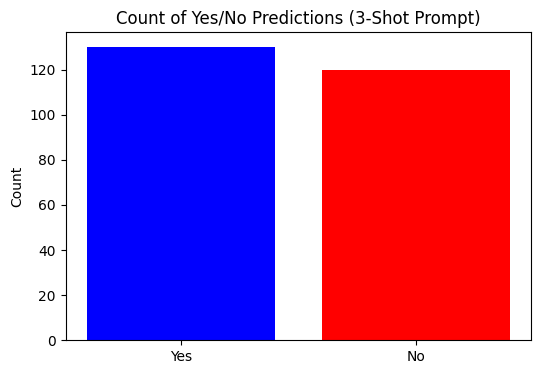

In [59]:
import random
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
model.to(device)

predictions = []

for i in tqdm(range(len(test_dataset))):
    prompt = ""
    for example in examples:
        statement = example['inputs'].replace('\n', ' ')
        answer = ["yes" if label == "plausible" else "no" for label in  example['targets']][0]
        prompt += f"Statement: {statement} Answer with 'yes' or 'no': {answer}\n"

    # Add the current test question to the prompt with instruction to answer with 'yes' or 'no'
    question = test_dataset[i]['input']
    prompt += f"Given the statement: {question} Is the statement true or false? Please respond 'yes' for true and 'no' for false."

    api_response = make_query(prompt)

    # Check if the API response contains the expected output
    if "error" in api_response:
        print(f"Error for input {formatted_input}: {api_response['error']}")
        continue

    # Assuming the API response is correctly formatted
    raw_prediction = api_response[0]['generated_text']
    prediction = "yes" if "yes" in raw_prediction.lower() else "no"
    predictions.append(prediction)

target_labels = [test_dataset[i]['target'] for i in range(len(test_dataset))]

results_df = pd.DataFrame({'Input': [test_dataset[i]['input'] for i in range(len(test_dataset))],
                           'Actual Target': target_labels,
                           'Predicted': predictions})

results_df.to_csv('3_shot_api.csv', index=False)

accuracy = accuracy_score(target_labels, predictions)
print(f"Accuracy: {accuracy}")

yes_count = predictions.count('yes')
no_count = predictions.count('no')

plt.figure(figsize=(6, 4))
plt.bar(['Yes', 'No'], [yes_count, no_count], color=['blue', 'red'])
plt.ylabel('Count')
plt.title('Count of Yes/No Predictions (3-Shot Prompt)')
plt.show()

## Model output

100%|██████████| 250/250 [00:36<00:00,  6.79it/s]


Accuracy: 0.54


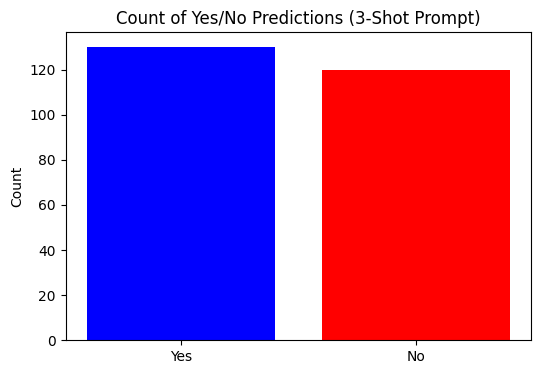

In [51]:
import random
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
model.to(device)

predictions = []

for i in tqdm(range(len(test_dataset))):
    prompt = ""
    for example in examples:
        statement = example['inputs'].replace('\n', ' ')
        answer = ["yes" if label == "plausible" else "no" for label in  example['targets']][0]
        prompt += f"Statement: {statement} Answer with 'yes' or 'no': {answer}\n"
    # print(prompt)

    # Add the current test question to the prompt with instruction to answer with 'yes' or 'no'
    question = test_dataset[i]['input']
    prompt += f"Given the statement: {question} Is the statement true or false? Please respond 'yes' for true and 'no' for false."

    # Move inputs to the GPU
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    # Move outputs to the CPU for decoding
    outputs = model.generate(inputs['input_ids'], max_length=128)
    raw_prediction = tokenizer.decode(outputs[0].cpu(), skip_special_tokens=True)


    prediction = "yes" if "yes" in raw_prediction.lower() else "no"
    predictions.append(prediction)

target_labels = [test_dataset[i]['target'] for i in range(len(test_dataset))]

results_df = pd.DataFrame({'Input': [test_dataset[i]['input'] for i in range(len(test_dataset))],
                           'Actual Target': target_labels,
                           'Predicted': predictions})

results_df.to_csv('3_shot.csv', index=False)

accuracy = accuracy_score(target_labels, predictions)
print(f"Accuracy: {accuracy}")

yes_count = predictions.count('yes')
no_count = predictions.count('no')

plt.figure(figsize=(6, 4))
plt.bar(['Yes', 'No'], [yes_count, no_count], color=['blue', 'red'])
plt.ylabel('Count')
plt.title('Count of Yes/No Predictions (3-Shot Prompt)')
plt.show()

# COT prompt

## model

100%|██████████| 250/250 [04:02<00:00,  1.03it/s]


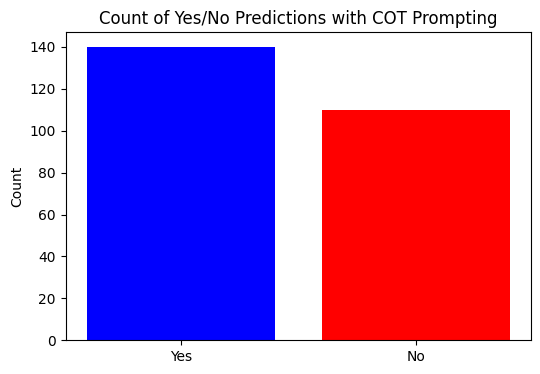

Accuracy: 0.508


In [74]:
import re
from tqdm import tqdm

def extract_yes_no(answer):
    # Define patterns that typically indicate a yes or no answer
    yes_pattern = re.compile(r"\b(yes|yeah|sure|correct|indeed|right|true)\b", re.IGNORECASE)
    no_pattern = re.compile(r"\b(no|nah|nope|false|incorrect|wrong|not)\b", re.IGNORECASE)

    # Check for 'yes' or 'no' in the answer
    if yes_pattern.search(answer):
        return "yes"
    elif no_pattern.search(answer):
        return "no"
    else:
        return "uncertain"

predictions = []
raw_predictions=[]

for question in tqdm(X_test):
    cot_input = f"Answer the following yes/no question by reasoning step-by-step: {question}"
    inputs = tokenizer(cot_input, return_tensors="pt", padding=True, truncation=True, max_length=512)
    # Move input tensors to GPU
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Generate the output with a specified maximum length
    outputs = model.generate(inputs['input_ids'], max_length=512)

    # Move outputs back to CPU
    outputs = outputs.to("cpu")

    raw_prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract yes/no from the prediction
    yes_no_prediction = extract_yes_no(raw_prediction)
    predictions.append(yes_no_prediction)
    raw_predictions.append(raw_prediction)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)

# Save predictions and actual targets to a CSV file
results_df = pd.DataFrame({'Input': X_test, 'Actual Target': y_test,'outout':raw_predictions, 'Predicted': predictions})
results_df.to_csv('model_predictions_cot.csv', index=False)

# Count the occurrences of 'yes' and 'no'
yes_count = predictions.count('yes')
no_count = predictions.count('no')

# Create a bar plot for the counts of 'yes' and 'no' predictions
plt.figure(figsize=(6, 4))
plt.bar(['Yes', 'No'], [yes_count, no_count], color=['blue', 'red'])
plt.ylabel('Count')
plt.title('Count of Yes/No Predictions with COT Prompting')
plt.show()

print(f"Accuracy: {accuracy}")

## API

100%|██████████| 250/250 [09:29<00:00,  2.28s/it]


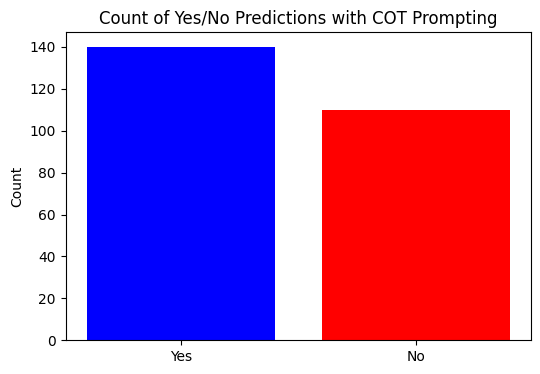

Accuracy: 0.508


In [68]:
import re
from tqdm import tqdm

def extract_yes_no(answer):
    # Define patterns that typically indicate a yes or no answer
    yes_pattern = re.compile(r"\b(yes|yeah|sure|correct|indeed|right|true)\b", re.IGNORECASE)
    no_pattern = re.compile(r"\b(no|nah|nope|false|incorrect|wrong|not)\b", re.IGNORECASE)

    # Check for 'yes' or 'no' in the answer
    if yes_pattern.search(answer):
        return "yes"
    elif no_pattern.search(answer):
        return "no"
    else:
        return "uncertain"

predictions = []

for question in tqdm(X_test):
    cot_input = f"Answer the following yes/no question by reasoning step-by-step: {question}"

    api_response = make_query(cot_input)

    # Check if the API response contains the expected output
    if "error" in api_response:
        print(f"Error for input {formatted_input}: {api_response['error']}")
        continue

    raw_prediction = api_response[0]['generated_text']

    # Extract yes/no from the prediction
    yes_no_prediction = extract_yes_no(raw_prediction)
    predictions.append(yes_no_prediction)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)

# Save predictions and actual targets to a CSV file
results_df = pd.DataFrame({'Input': X_test, 'Actual Target': y_test, 'Predicted': predictions})
results_df.to_csv('cot_api.csv', index=False)

# Count the occurrences of 'yes' and 'no'
yes_count = predictions.count('yes')
no_count = predictions.count('no')

# Create a bar plot for the counts of 'yes' and 'no' predictions
plt.figure(figsize=(6, 4))
plt.bar(['Yes', 'No'], [yes_count, no_count], color=['blue', 'red'])
plt.ylabel('Count')
plt.title('Count of Yes/No Predictions with COT Prompting')
plt.show()

print(f"Accuracy: {accuracy}")

# Comparison

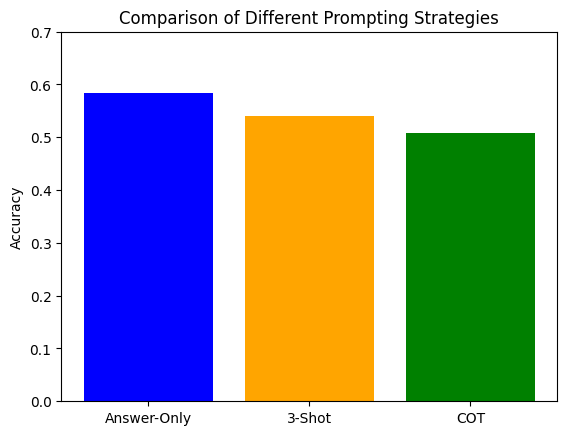

In [71]:
import matplotlib.pyplot as plt

# Data
methods = ['Answer-Only', '3-Shot', 'COT']
accuracy_values = [0.584, 0.54, 0.508]

# Create bar plot
plt.bar(methods, accuracy_values, color=['blue', 'orange', 'green'])
plt.ylabel('Accuracy')
plt.title('Comparison of Different Prompting Strategies')
plt.ylim(0, 0.7)
plt.show()
